## Imports

In [1]:
# ======================
# OS AND FILE MANAGEMENT
# ======================
import shutil
import random
from glob import glob
import pickle
import re
import xml.etree.ElementTree as ET

import sys
import os

# Go 2 levels up from current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Add to sys.path if not present
if project_root not in sys.path:
    sys.path.insert(0, project_root)


# ================================
# SCIENTIFIC COMPUTING + DATA I/O
# ================================
import numpy as np
import pandas as pd

# ==================
# IMAGE PROCESSING
# ==================
import cv2
import pydicom

# Image Augmentation (Albumentations)
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, Affine,
    GaussianBlur, CLAHE, RandomGamma, GaussNoise
)

# ================
# VISUALIZATION
# ================
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ===========================
# MACHINE LEARNING UTILITIES
# ===========================
from sklearn.model_selection import train_test_split
from collections import defaultdict

# ===========================
# CUSTOM PROJECT IMPORTS
# (new structure under src/)
# ===========================

# --- Preprocessing ---
from src.preprocessing.uid_mapping import getUID_path
from src.preprocessing.dicom_io import read_dicom_image
from src.preprocessing.xml_parsing import extract_bounding_boxes
from src.preprocessing.dataset_building import (
    create_dataset,
    get_images_by_patient_id
)
from src.preprocessing.yolo_conversion import preprocess_images

# Balanced sampling utilities
from src.preprocessing.sampling import (
    relaxed_stratified_sample,
    add_more_patients,
    get_target_sample,
    adjust_sample_size,
    calculate_stage_distribution,
    compare_distributions,
    check_balance
)

# --- Augmentation ---
from src.augmentation.augmentation_yolo import (
    augment_yolo_images_train,
    augment_yolo_images_val
)

# --- Splitting ---
from src.splitting.dataset_splitting import split_data

# --- Statistics ---
from src.statistics.patient_label_statistics import (
    count_labels_by_class,
    count_labels_by_class_and_source,
    count_images_labels_patients_by_class
)

# --- Visualization ---
from src.visualization.plot_bboxes import (
    visualize_image_with_bboxes,
    visualize_image_with_bboxes_legend
)
from src.visualization.patient_visualization import visualize_image_by_uid
from src.visualization.yolo_visualization import visualize_yolo_images

# --- Utility Tools ---
from src.utils.file_utils import (
    load_dataset,
    loadFileInformation
)
    
from src.utils.extract_number import extract_number
from src.splitting.dataset_splitting import split_data_2datasets
from src.utils.subject_utils import (
    count_unique_subject_ids,
    patient_count_by_group,
    count_labels_by_class_and_source,
    count_labels_by_class,
    count_images_labels_patients_by_class_2datasets,
    count_images_labels_patients_by_class_total,    
)   

/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Creating the Data Set (Images)

## Split the data
* Data was splited **70% train, 15% val, 15% test**

In [2]:
input_dir = os.path.join('../data/', 'yolo_2datasets')
output_dir = os.path.join('../data/yolo_2datasets', 'patient_split_2datasets')

In [3]:
# Example usage
base_directory = os.path.join('../../data/yolo/yolo_2datasets', 'patient_split_2datasets') # Replace with actual dataset path
class_counts = count_images_labels_patients_by_class_total(base_directory)

# Print results
print("Final Class Counts (Aggregated Across Train, Val, Test):")
print(class_counts)

Final Class Counts (Aggregated Across Train, Val, Test):
defaultdict(<function count_images_labels_patients_by_class_total.<locals>.<lambda> at 0x3042cfec0>, {'A': {'images': 3529, 'labels': 3529, 'patients': 77}, 'B': {'images': 3021, 'labels': 3021, 'patients': 37}, 'E': {'images': 2227, 'labels': 2227, 'patients': 119}, 'G': {'images': 3988, 'labels': 3988, 'patients': 94}})


### **Train Data (70%)**

In [4]:
split_dir_train = os.path.join('../../data/yolo/yolo_2datasets', 'patient_split_2datasets/train')
class_counts, patient_ids = count_images_labels_patients_by_class_2datasets(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")
    print(f"  - {counts['patients_standard']} LUNG-PET-CX patients")
    print(f"  - {counts['patients_lung1']} LUNG1 patients")

print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id} (All patients): {ids['all']}")
    print(f"Class {class_id} (LUNG-PET-CX patients): {ids['standard']}")
    print(f"Class {class_id} (LUNG1 patients): {ids['lung1']}")

Counts of images, labels, and patients by class:
Class G: 2935 images, 2935 labels, 68 unique patients
  - 29 LUNG-PET-CX patients
  - 39 LUNG1 patients
Class E: 1455 images, 1455 labels, 82 unique patients
  - 3 LUNG-PET-CX patients
  - 79 LUNG1 patients
Class A: 2546 images, 2546 labels, 59 unique patients
  - 59 LUNG-PET-CX patients
  - 0 LUNG1 patients
Class B: 2303 images, 2303 labels, 27 unique patients
  - 27 LUNG-PET-CX patients
  - 0 LUNG1 patients

List of unique patient IDs by class:
Class G (All patients): ['G0002', 'G0003', 'G0004', 'G0005', 'G0006', 'G0007', 'G0011', 'G0013', 'G0014', 'G0015', 'G0017', 'G0018', 'G0019', 'G0024', 'G0025', 'G0026', 'G0028', 'G0029', 'G0031', 'G0032', 'G0036', 'G0039', 'G0040', 'G0041', 'G0043', 'G0044', 'G0050', 'G0056', 'G0062', 'G_LUNG1-007', 'G_LUNG1-014', 'G_LUNG1-027', 'G_LUNG1-061', 'G_LUNG1-063', 'G_LUNG1-064', 'G_LUNG1-078', 'G_LUNG1-082', 'G_LUNG1-098', 'G_LUNG1-122', 'G_LUNG1-145', 'G_LUNG1-146', 'G_LUNG1-202', 'G_LUNG1-222', 'G_L

### **Validation Data (15%)**

In [5]:
split_dir_train = os.path.join('../../data/yolo/yolo_2datasets', 'patient_split_2datasets/val')
class_counts, patient_ids = count_images_labels_patients_by_class_2datasets(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")
    print(f"  - {counts['patients_standard']} LUNG-PET-CX patients")
    print(f"  - {counts['patients_lung1']} LUNG1 patients")

print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id} (All patients): {ids['all']}")
    print(f"Class {class_id} (LUNG-PET-CX patients): {ids['standard']}")
    print(f"Class {class_id} (LUNG1 patients): {ids['lung1']}")

Counts of images, labels, and patients by class:
Class G: 497 images, 497 labels, 12 unique patients
  - 4 LUNG-PET-CX patients
  - 8 LUNG1 patients
Class E: 470 images, 470 labels, 19 unique patients
  - 1 LUNG-PET-CX patients
  - 18 LUNG1 patients
Class A: 508 images, 508 labels, 10 unique patients
  - 10 LUNG-PET-CX patients
  - 0 LUNG1 patients
Class B: 364 images, 364 labels, 5 unique patients
  - 5 LUNG-PET-CX patients
  - 0 LUNG1 patients

List of unique patient IDs by class:
Class G (All patients): ['G0008', 'G0010', 'G0033', 'G0046', 'G_LUNG1-167', 'G_LUNG1-253', 'G_LUNG1-264', 'G_LUNG1-346', 'G_LUNG1-358', 'G_LUNG1-359', 'G_LUNG1-366', 'G_LUNG1-391']
Class G (LUNG-PET-CX patients): ['G0008', 'G0010', 'G0033', 'G0046']
Class G (LUNG1 patients): ['G_LUNG1-167', 'G_LUNG1-253', 'G_LUNG1-264', 'G_LUNG1-346', 'G_LUNG1-358', 'G_LUNG1-359', 'G_LUNG1-366', 'G_LUNG1-391']
Class E (All patients): ['E0003', 'E_LUNG1-017', 'E_LUNG1-040', 'E_LUNG1-043', 'E_LUNG1-077', 'E_LUNG1-113', 'E_LUN

### **Test Data (15%)**

In [6]:
split_dir_train = os.path.join('../../data/yolo/yolo_2datasets', 'patient_split_2datasets/test')
class_counts, patient_ids = count_images_labels_patients_by_class_2datasets(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")
    print(f"  - {counts['patients_standard']} LUNG-PET-CX patients")
    print(f"  - {counts['patients_lung1']} LUNG1 patients")

print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id} (All patients): {ids['all']}")
    print(f"Class {class_id} (LUNG-PET-CX patients): {ids['standard']}")
    print(f"Class {class_id} (LUNG1 patients): {ids['lung1']}")

Counts of images, labels, and patients by class:
Class G: 556 images, 556 labels, 14 unique patients
  - 5 LUNG-PET-CX patients
  - 9 LUNG1 patients
Class E: 302 images, 302 labels, 18 unique patients
  - 1 LUNG-PET-CX patients
  - 17 LUNG1 patients
Class A: 475 images, 475 labels, 8 unique patients
  - 8 LUNG-PET-CX patients
  - 0 LUNG1 patients
Class B: 354 images, 354 labels, 5 unique patients
  - 5 LUNG-PET-CX patients
  - 0 LUNG1 patients

List of unique patient IDs by class:
Class G (All patients): ['G0001', 'G0012', 'G0030', 'G0042', 'G0049', 'G_LUNG1-010', 'G_LUNG1-050', 'G_LUNG1-086', 'G_LUNG1-135', 'G_LUNG1-150', 'G_LUNG1-206', 'G_LUNG1-266', 'G_LUNG1-386', 'G_LUNG1-413']
Class G (LUNG-PET-CX patients): ['G0001', 'G0012', 'G0030', 'G0042', 'G0049']
Class G (LUNG1 patients): ['G_LUNG1-010', 'G_LUNG1-050', 'G_LUNG1-086', 'G_LUNG1-135', 'G_LUNG1-150', 'G_LUNG1-206', 'G_LUNG1-266', 'G_LUNG1-386', 'G_LUNG1-413']
Class E (All patients): ['E0005', 'E_LUNG1-003', 'E_LUNG1-029', 'E_LU

## Data Augmentation for Training and Validation

<span style="font-size:18px; font-weight:bold;">Purpose of Augmentation</span>  
Data augmentation is used to artificially expand the training dataset by applying transformations to existing images. This helps improve the model's generalization by exposing it to a variety of variations and preventing overfitting.  
<br>
<span style="font-size:18px; font-weight:bold;">Augmentation Strategies for Training</span>  
In the training dataset, different augmentation pipelines were applied to balance the class distribution and enhance the dataset's diversity. Special consideration was given to **Class E**, which had only **201 images** compared to the **other classes with over 3,000 images**. To account for this imbalance, **more intensive augmentations** were applied to Class E to generate a sufficient number of diverse samples.  
* All images were augmented until they **reached the same number of images as the class with the most images** (in this case until they reached **2566 images** - same number as the class G).  
<br>

<span style="font-size:16px; font-weight:bold;">Transformations Applied:</span>  
1. **Horizontal Flip**: Introduced variation by flipping images horizontally.  
2. **Random Brightness/Contrast**: Adjusted brightness and contrast to simulate different imaging conditions.  
3. **Affine Transformations**:  
   - Small translations (e.g., 1-2%) and scaling (e.g., 95%-105%).  
   - Slight rotations (e.g., -2° to 2°) to mimic slight misalignments.  
4. **Gaussian Blur**: Added blur to simulate lower-quality imaging conditions.  
5. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Enhanced local contrast in images.  
6. **Random Gamma Adjustments**: Adjusted image gamma to alter overall brightness.  

For Class E, the **intense augmentation pipeline** included:  
- Larger translations (5%-10%) and scaling variations (80%-120%).  
- More pronounced rotations (-10° to 10°) and shear transformations (-5° to 5°).  
- Increased blur and contrast adjustments to maximize variation.  
<br>

<span style="font-size:18px; font-weight:bold;">Contextual Considerations</span>  
Since the data consists of **CT/PET scans**, it was important to apply transformations that preserve the anatomical and diagnostic integrity of the images. For example:  
- **Rotations and translations** were kept small to avoid unrealistic spatial changes.  
- **Brightness/contrast adjustments** were restricted to values that align with possible differences in imaging modalities.  
- **Gaussian blur** and **CLAHE** simulated conditions such as scanner noise or imaging artifacts.  
<br>

<span style="font-size:18px; font-weight:bold;">Augmentation for Validation</span>  
For the validation dataset, fewer augmentations were applied to ensure that the data closely resembles real-world conditions. The augmentations for validation included:  
1. **Horizontal Flip (5%)**: Small chance of flipping for minor variation.  
2. **Random Brightness/Contrast (3%-5%)**: Simulated subtle differences in imaging conditions.  
3. **Affine Transformations**:  
   - Tiny translations (1%-2%) and scaling (95%-105%).  
   - Slight rotations (-2° to 2°).  
* All images were augmented until they **reached the same number of images as the class with the most images** (in this case until they reached **508 images** - same number as the class A).  
<br>

<span style="font-size:18px; font-weight:bold;">Rationale for Choosing Augmentations</span>  
- CT/PET scans are highly sensitive to transformations that distort anatomical features. Therefore, care was taken to ensure that augmentations like large rotations or extreme brightness changes were avoided.  
- **For training**: Aggressive augmentations were used for the underrepresented Class E to create enough diverse samples without straying too far from realistic imaging.  
- **For validation**: Minimal augmentations were applied to mimic real-world test data, ensuring the evaluation remained unbiased.


### **Train**

In [7]:
input_dir_train= os.path.join('../../data/yolo/yolo_2datasets', 'patient_split_2datasets/train')
output_dir_train= os.path.join('../../data/yolo/yolo_2datasets', 'patient_augmented_2datasets/train')

In [15]:
augment_yolo_images_train(input_dir_train, output_dir_train, 2950, target_size=(512, 512))


Augmentation completed.
  Total images for Class 0 after augmentation: 2950
  Total images for Class 1 after augmentation: 2950
  Total images for Class 2 after augmentation: 2950
  Total images for Class 3 after augmentation: 2950


In [8]:
split_dir = os.path.join('../../data/yolo/yolo_2datasets', 'patient_augmented_2datasets/train')
class_counts, patient_ids = count_images_labels_patients_by_class_2datasets(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class G: 2950 images, 2950 labels, 68 unique patients

List of unique patient IDs by class:
Class E: 2950 images, 2950 labels, 82 unique patients

List of unique patient IDs by class:
Class A: 2950 images, 2950 labels, 59 unique patients

List of unique patient IDs by class:
Class B: 2950 images, 2950 labels, 27 unique patients

List of unique patient IDs by class:
Class G: {'all': ['G0002', 'G0003', 'G0004', 'G0005', 'G0006', 'G0007', 'G0011', 'G0013', 'G0014', 'G0015', 'G0017', 'G0018', 'G0019', 'G0024', 'G0025', 'G0026', 'G0028', 'G0029', 'G0031', 'G0032', 'G0036', 'G0039', 'G0040', 'G0041', 'G0043', 'G0044', 'G0050', 'G0056', 'G0062', 'G_LUNG1-007', 'G_LUNG1-014', 'G_LUNG1-027', 'G_LUNG1-061', 'G_LUNG1-063', 'G_LUNG1-064', 'G_LUNG1-078', 'G_LUNG1-082', 'G_LUNG1-098', 'G_LUNG1-122', 'G_LUNG1-145', 'G_LUNG1-146', 'G_LUNG1-202', 'G_LUNG1-222', 'G_LUNG1-295', 'G_LUNG1-296', 'G_LUNG1-302', 'G_LUNG1-321', 'G_LUNG1-325', 'G_LUNG1-326', 'G_L

### **Validation**

In [9]:
input_dir_val= os.path.join('../../data/yolo/yolo_2datasets', 'patient_split_2datasets/val')
output_dir_val= os.path.join('../../data/yolo/yolo_2datasets', 'patient_augmented_2datasets/val')

In [18]:
augment_yolo_images_val(input_dir_val, output_dir_val, 510, target_size=(512, 512))


Augmentation completed.
  Total images for Class 1 after augmentation: 510
  Total images for Class 3 after augmentation: 510
  Total images for Class 2 after augmentation: 510
  Total images for Class 0 after augmentation: 510


In [10]:
split_dir = os.path.join('../../data/yolo/yolo_2datasets', 'patient_augmented_2datasets/val')
class_counts, patient_ids = count_images_labels_patients_by_class_2datasets(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['total_patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class G: 510 images, 510 labels, 12 unique patients

List of unique patient IDs by class:
Class E: 510 images, 510 labels, 19 unique patients

List of unique patient IDs by class:
Class A: 510 images, 510 labels, 10 unique patients

List of unique patient IDs by class:
Class B: 510 images, 510 labels, 5 unique patients

List of unique patient IDs by class:
Class G: {'all': ['G0008', 'G0010', 'G0033', 'G0046', 'G_LUNG1-167', 'G_LUNG1-253', 'G_LUNG1-264', 'G_LUNG1-346', 'G_LUNG1-358', 'G_LUNG1-359', 'G_LUNG1-366', 'G_LUNG1-391'], 'standard': ['G0008', 'G0010', 'G0033', 'G0046'], 'lung1': ['G_LUNG1-167', 'G_LUNG1-253', 'G_LUNG1-264', 'G_LUNG1-346', 'G_LUNG1-358', 'G_LUNG1-359', 'G_LUNG1-366', 'G_LUNG1-391']}
Class E: {'all': ['E0003', 'E_LUNG1-017', 'E_LUNG1-040', 'E_LUNG1-043', 'E_LUNG1-077', 'E_LUNG1-113', 'E_LUNG1-124', 'E_LUNG1-140', 'E_LUNG1-142', 'E_LUNG1-172', 'E_LUNG1-182', 'E_LUNG1-191', 'E_LUNG1-254', 'E_LUNG1-262', 'E_LUNG1-267',

### Vizualizing the final augmented images and the bboxes

UID: E, Image: E_LUNG1-142_12-14-2006-StudyID-NA-31335_18.jpg


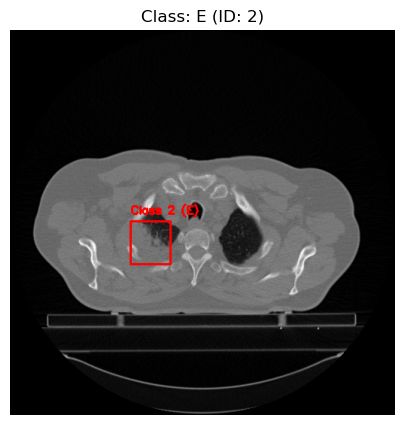

UID: E, Image: E_LUNG1-113_07-07-2006-StudyID-NA-44497_71.jpg


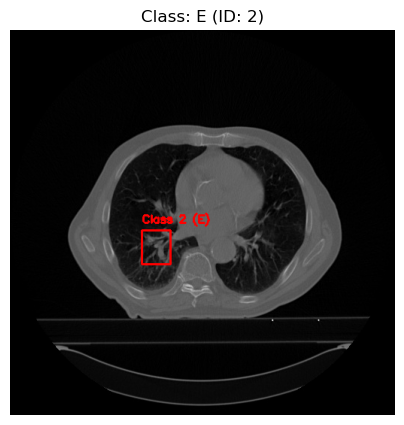

UID: E, Image: E_LUNG1-040_01-01-2014-StudyID-NA-01636_53_aug_25.jpg


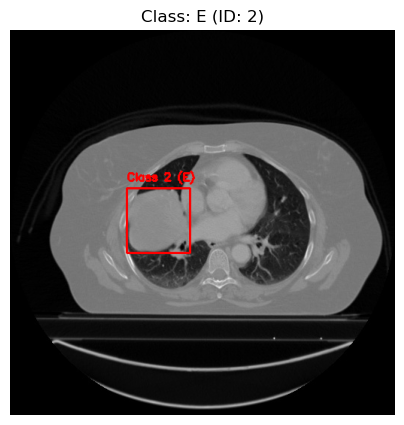

UID: B0034, Image: B0034_1.3.6.1.4.1.14519.5.2.1.6655.2359.240331973472601578078018858147_aug_117.jpg


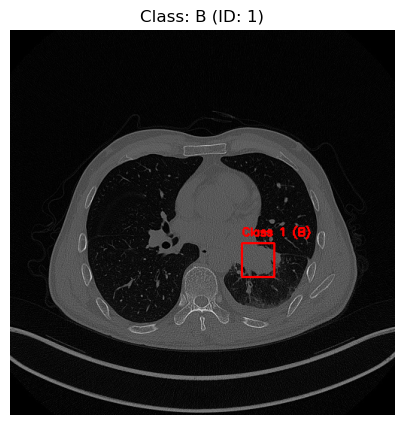

UID: E0003, Image: E0003_1.3.6.1.4.1.14519.5.2.1.6655.2359.316642041886651069140739189106.jpg


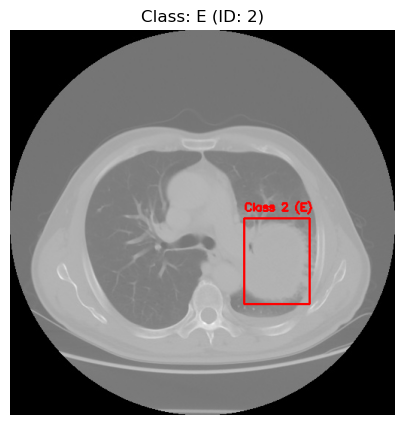

In [25]:
class_mapping = {
    "A": 0,  # Adenocarcinoma
    "B": 1,  # Small Cell Carcinoma
    "E": 2,  # Large Cell Carcinoma
    "G": 3   # Squamous Cell Carcinoma
}
visualize_yolo_images(split_dir, class_mapping, num_images=5)